El autoencoder ha sido ideado a partir de un encoder y un decoder. El encoder genera dos vectores, uno es la media y otro la desviación típica. Generando un vector aleatorio que represente una distribución normal, generamos el vector latente z. A partir de este vector latente, el decoder constituye la salida.Para la función de loss, utiliza squared difference combinada con Kullback-Leibler divergence.

### Importaciones

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras import backend as K
from keras.layers import (Input, InputLayer, Dense, Lambda, Layer, Add, Multiply)
from keras.models import Model, Sequential
from keras.datasets import mnist
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
from keras.utils.vis_utils import model_to_dot, plot_model

### Cargamos los datos

In [108]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [109]:
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0

### Encoder

In [110]:
##Creamos la capa de entrada
inputs = Input(shape=(original_dim,),name='encoder_input')
##Creamos capa intermedia
x_encoder = Dense(intermediate_dim,activation='relu')(inputs)
##Creamos dos capas de salida,media y log_desviacion(se usa en lugar de la estándar)
media = Dense(latent_dim,name='media')(x_encoder)
log_desviacion = Dense(latent_dim,name='log_desviacion')(x_encoder)

### Decoder

In [111]:
##Creamos capa de entrada del decodificador
latent_vector = Input(shape=(latent_dim,), name='latent_vector')
x_decoder = Dense(intermediate_dim, activation='relu')(latent_vector)
outputs = Dense(original_dim, activation='sigmoid')(x_decoder)

### Latent vector

In [112]:
def sampler(args):
    z_mean, z_log = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # mean and log of variance of Q(z|X)
    # we sample from the standard normal a matrix of batch_size * latent_size (taking into account minibatches)
    epsilon = K.random_normal(shape=(batch,dim))# by default, random_normal has mean=0 and std=1.0
    # sampling from Z~N(μ, σ^2) is the same as sampling from μ + σX, X~N(0,1)
    return z_mean + K.exp(0.5 * z_log) * epsilon
  
z = Lambda(sampler)([media, log_desviacion])

### Compilación de modelos-VAE

In [66]:
##Instanciamos el encoder
encoder = Model(inputs,[media,log_desviacion,z],name='encoder')
encoder.summary()
##Instanciamos el decoder
decoder = Model(latent_vector,outputs,name='decoder')
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 256)          200960      encoder_input[0][0]              
__________________________________________________________________________________________________
media (Dense)                   (None, 2)            514         dense_18[0][0]                   
__________________________________________________________________________________________________
log_desviacion (Dense)          (None, 2)            514         dense_18[0][0]                   
____________________________________________________________________________________________

In [68]:
##Creamos el modelo final
outputs_final= decoder(encoder(inputs)[2])
vae = Model(inputs,outputs_final,name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


### VAE loss

In [74]:
def vae_loss(inputs, outputs):
    reconstruction_loss = K.sum(K.square(outputs-inputs))
    kl_loss = - 0.5 * K.mean(1 + log_desviacion - K.square(media) - K.exp(log_desviacion), axis=-1)
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    return total_loss

### Entrenamiento

In [75]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 156us/step - loss: 4744.5441 - val_loss: 3998.8357
Epoch 2/50
60000/60000 [==============================] - 7s 117us/step - loss: 3840.4665 - val_loss: 3715.8863
Epoch 3/50
60000/60000 [==============================] - 7s 113us/step - loss: 3678.8694 - val_loss: 3608.6111
Epoch 4/50
60000/60000 [==============================] - 7s 114us/step - loss: 3591.5159 - val_loss: 3547.3083
Epoch 5/50
60000/60000 [==============================] - 7s 114us/step - loss: 3526.0116 - val_loss: 3493.0242
Epoch 6/50
60000/60000 [==============================] - 7s 114us/step - loss: 3473.5070 - val_loss: 3449.2096
Epoch 7/50
60000/60000 [==============================] - 7s 114us/step - loss: 3427.7517 - val_loss: 3425.1105
Epoch 8/50
60000/60000 [==============================] - 7s 113us/step - loss: 3389.6670 - val_loss: 3386.2208
Epoch 

### Scatters

Text(0.5, 1.0, 'Latent_vector')

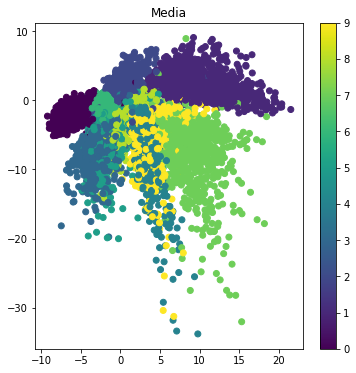

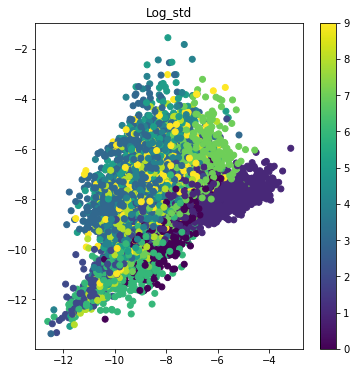

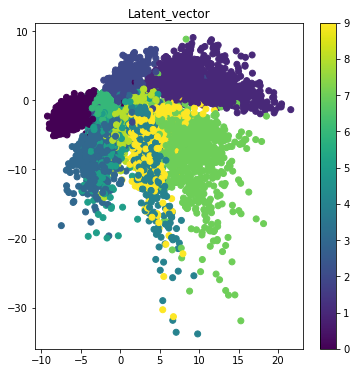

In [106]:
media,log_desviacion,z  = encoder.predict(x_test,batch_size=batch_size)
#Figura 1-media
plt.figure(figsize=(6, 6))
plt.scatter(media[:, 0], media[:, 1], c=y_test)
plt.colorbar()
plt.title('Media')
#Figura 2-log_std
plt.figure(figsize=(6, 6))
plt.scatter(log_desviacion[:, 0], log_desviacion[:, 1], c=y_test)
plt.colorbar()
plt.title('Log_std')
#Figura 3-latent_vector
plt.figure(figsize=(6, 6))
plt.scatter(z[:, 0], z[:, 1], c=y_test)
plt.colorbar()
plt.title('Latent_vector')
##plt.xlabel("z[0]")
##plt.ylabel("z[1]")

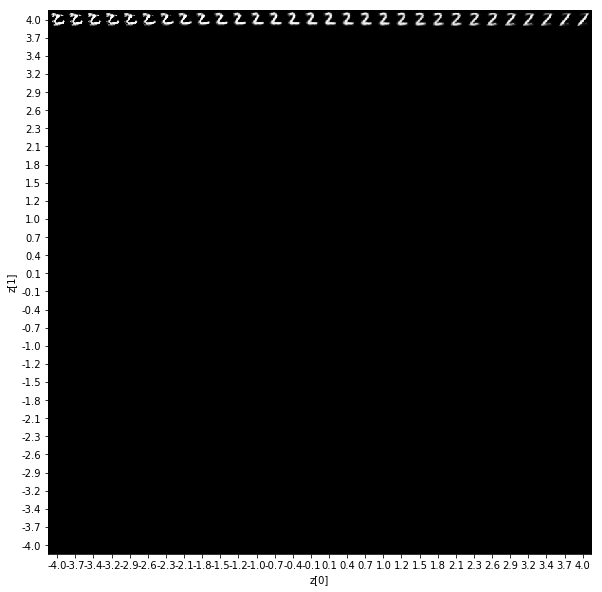

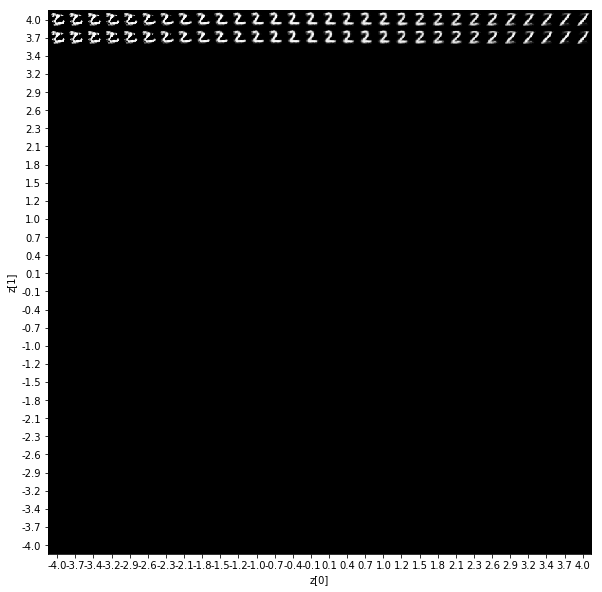

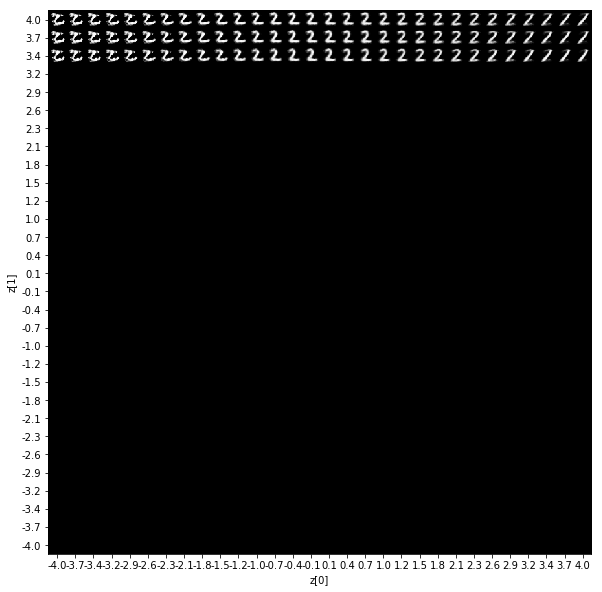

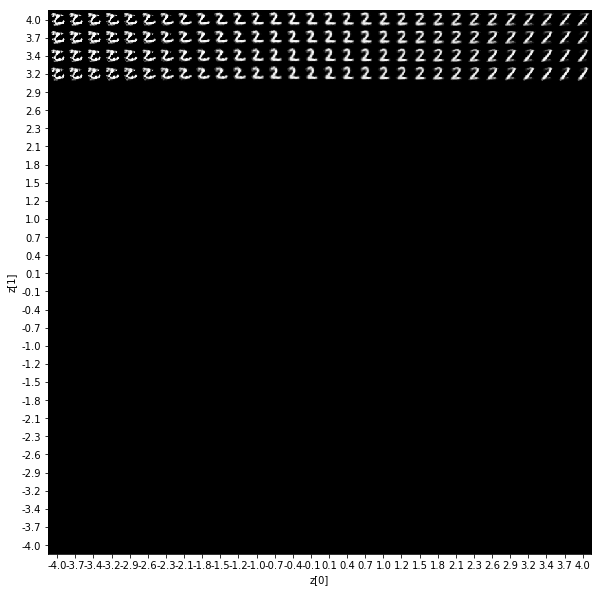

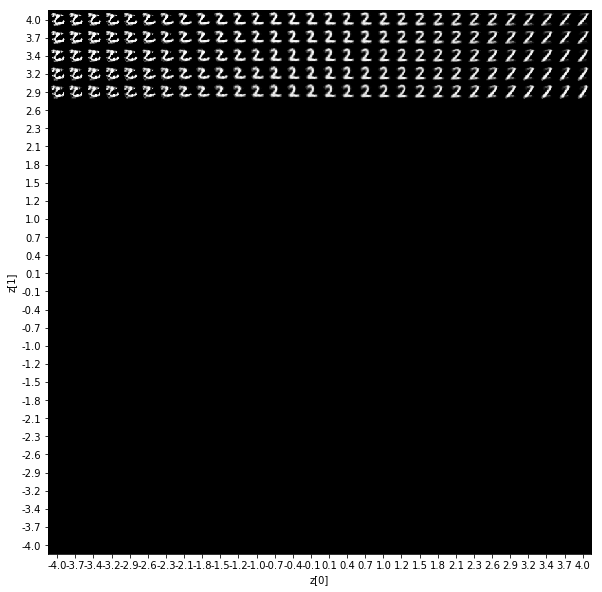

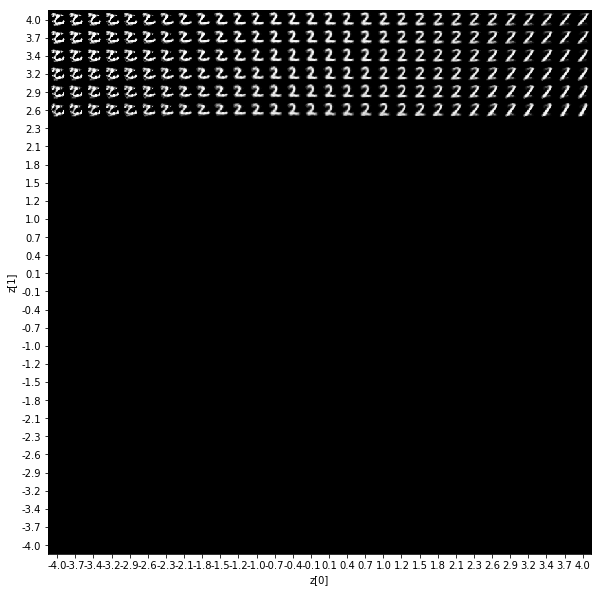

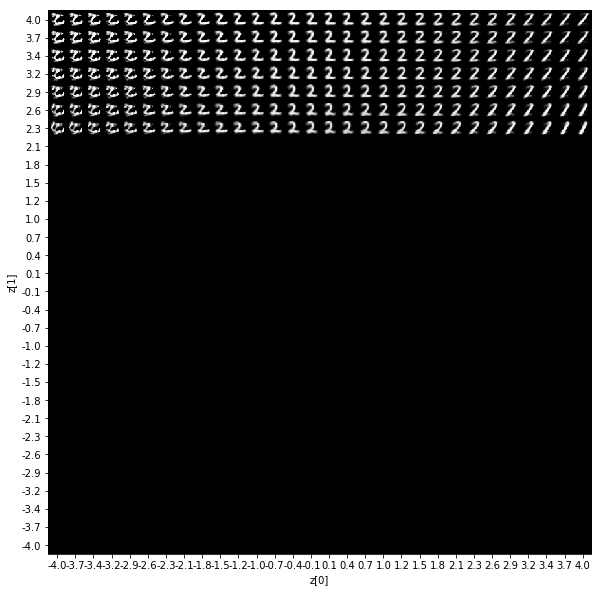

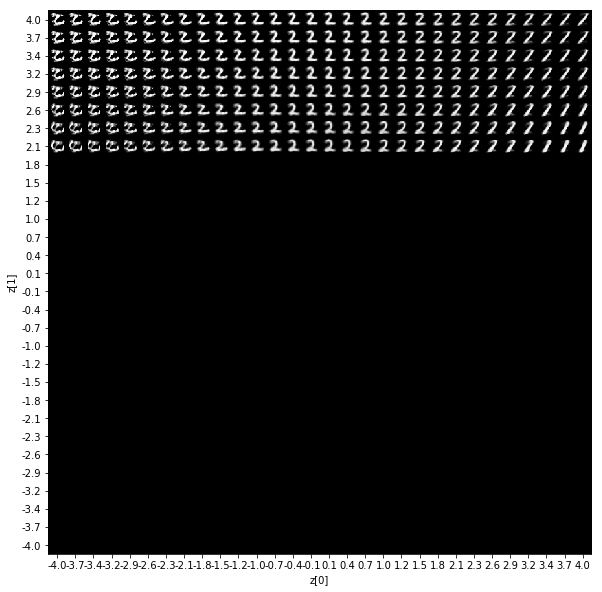

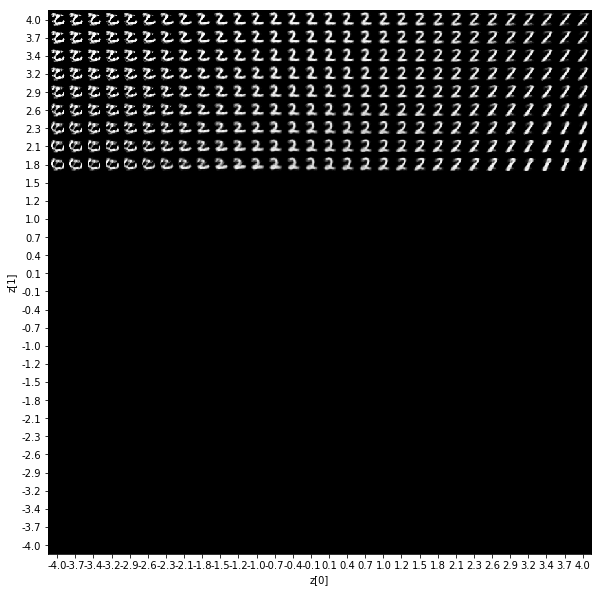

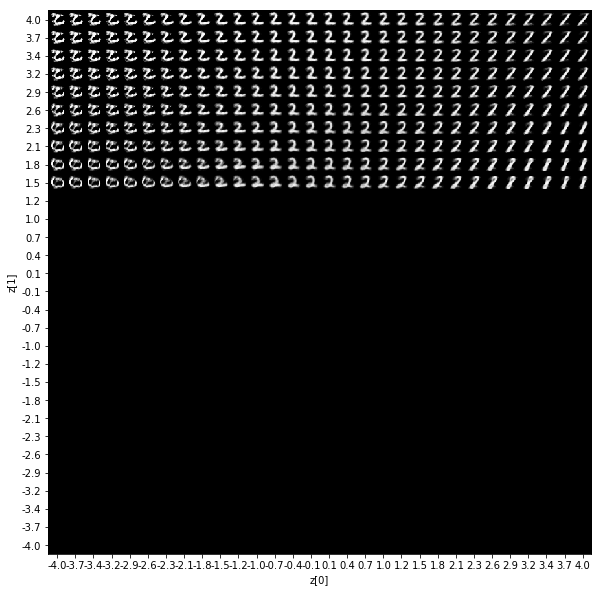

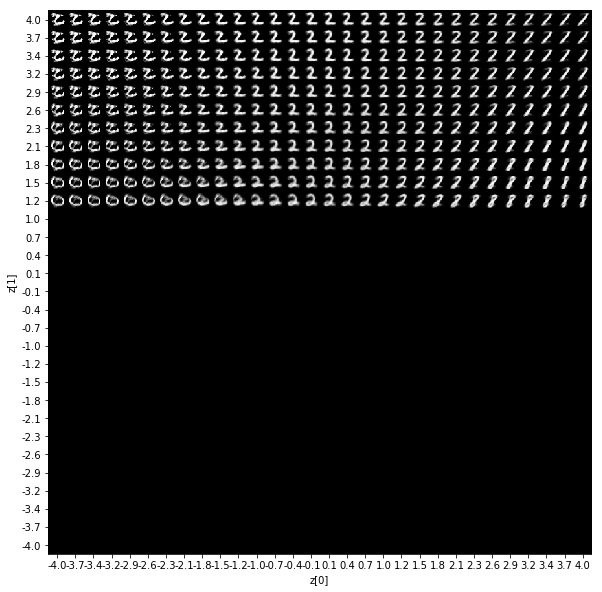

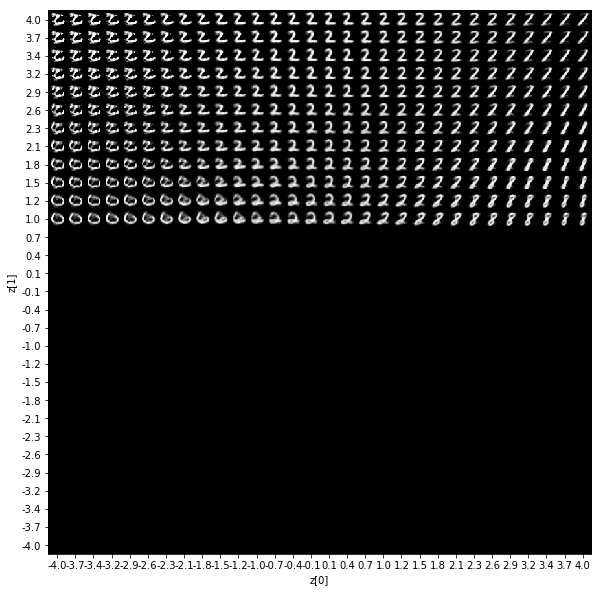

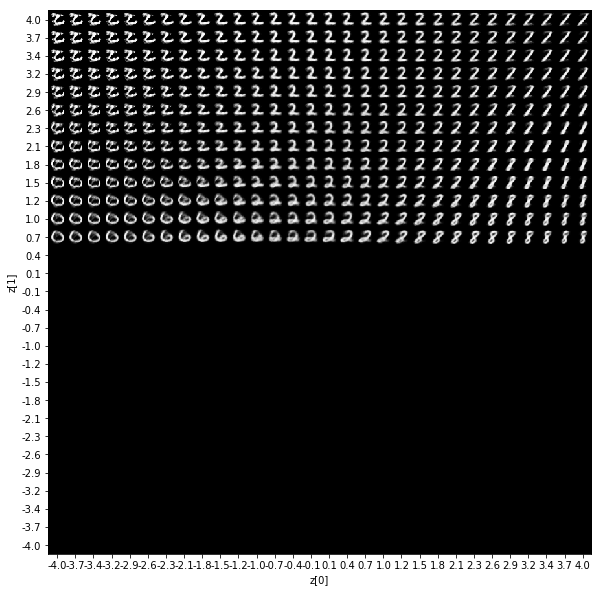

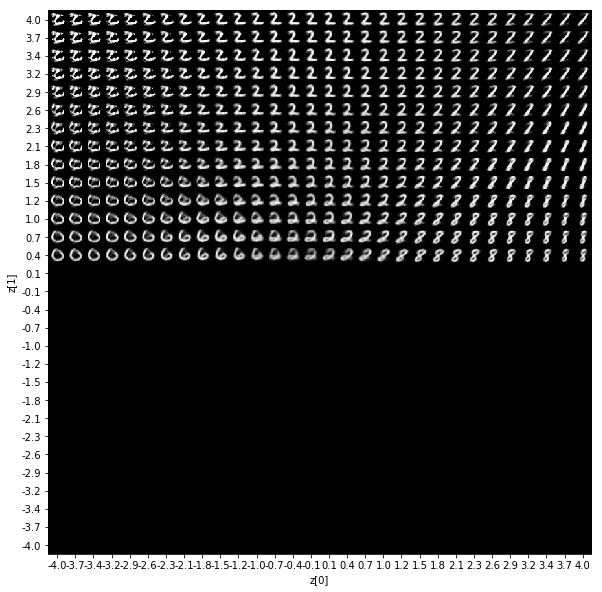

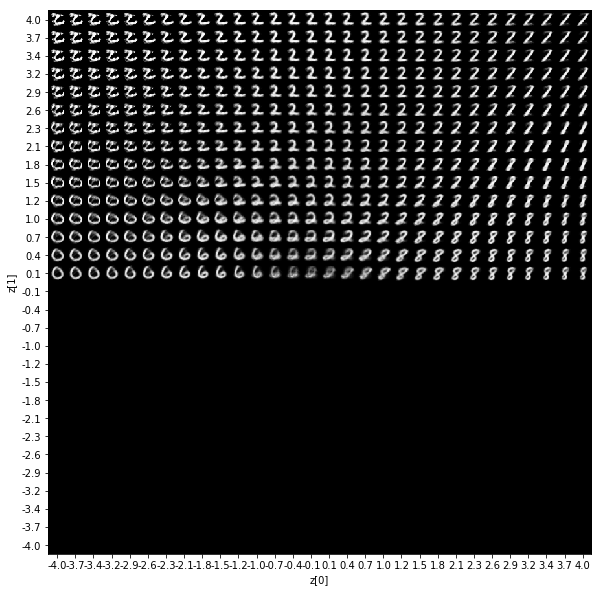

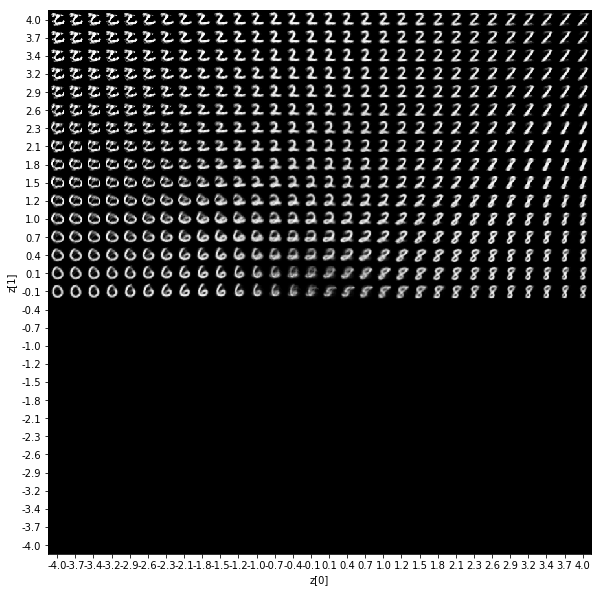

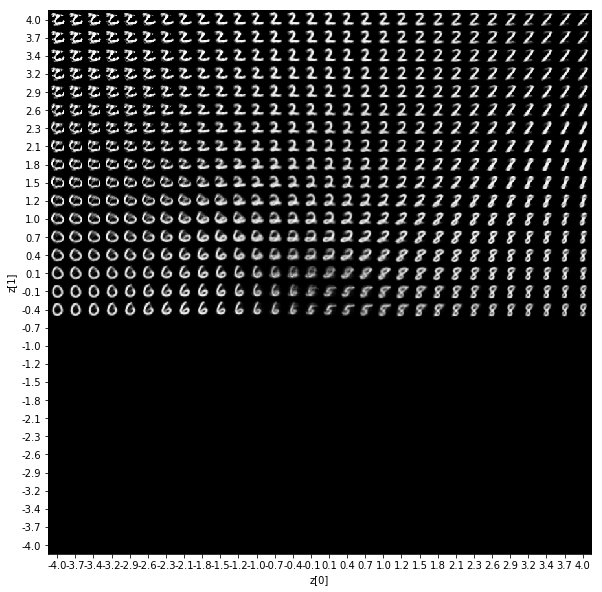

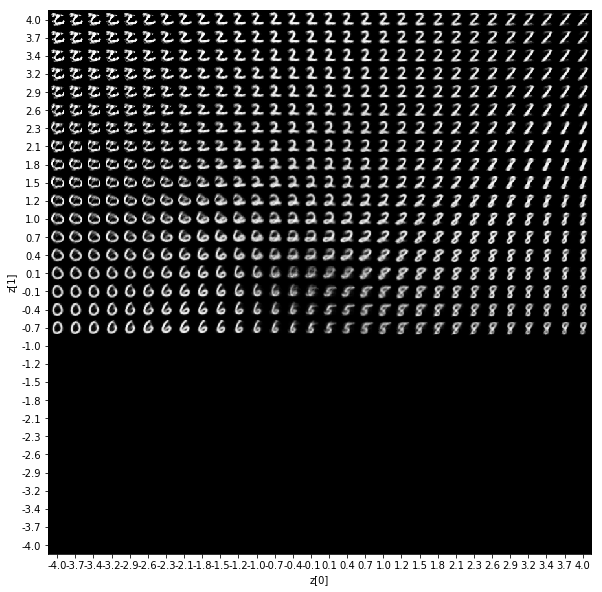

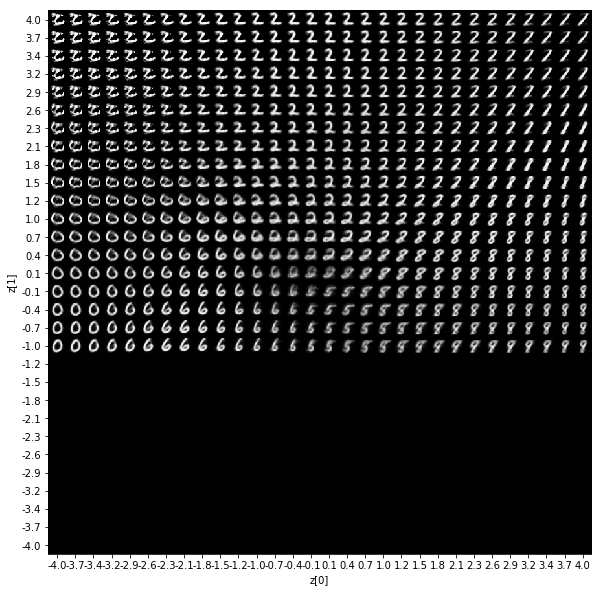

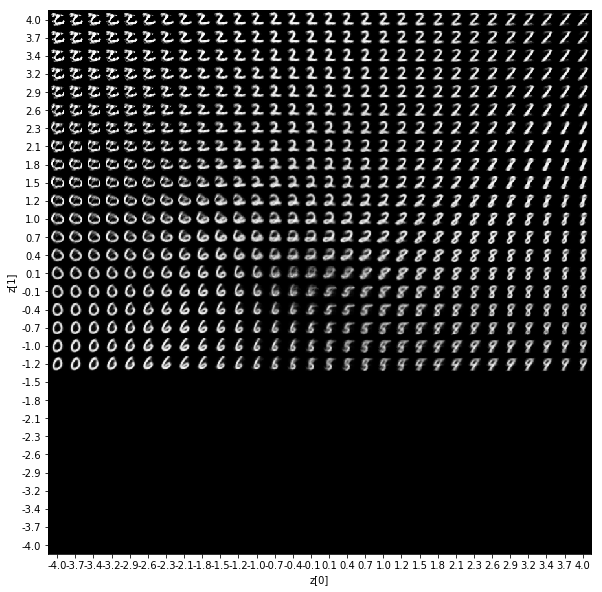

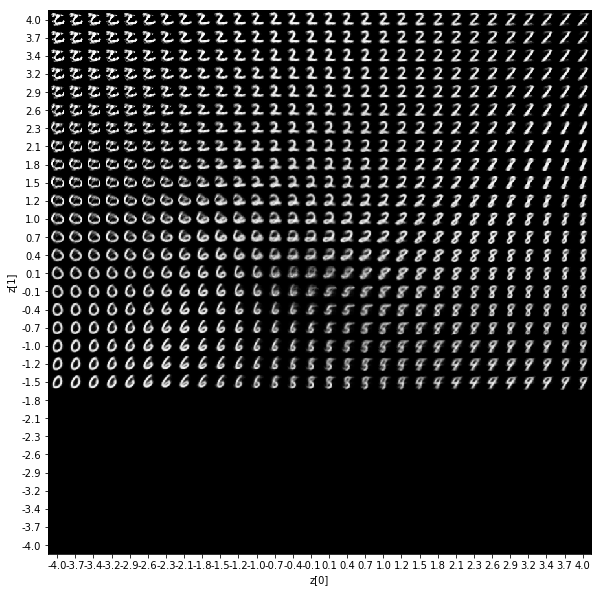

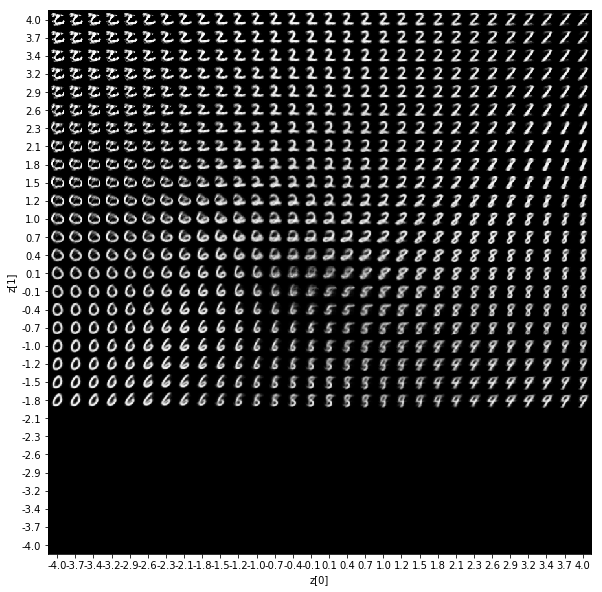

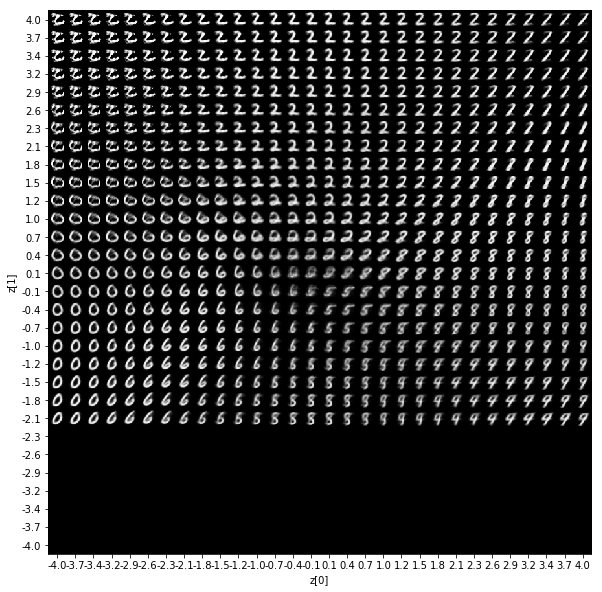

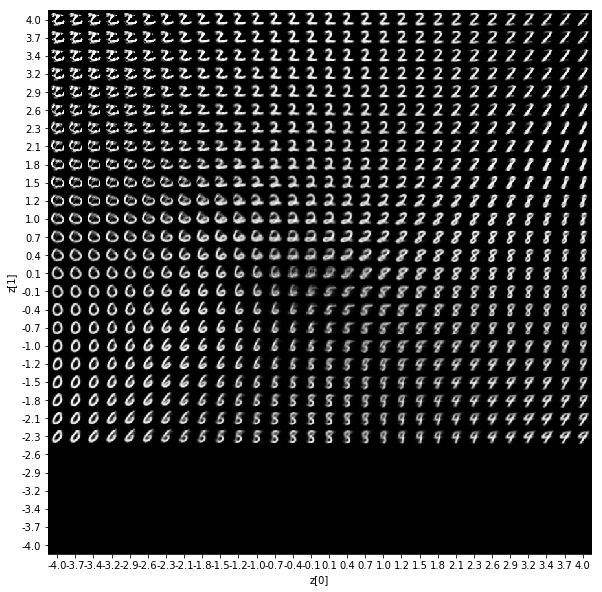

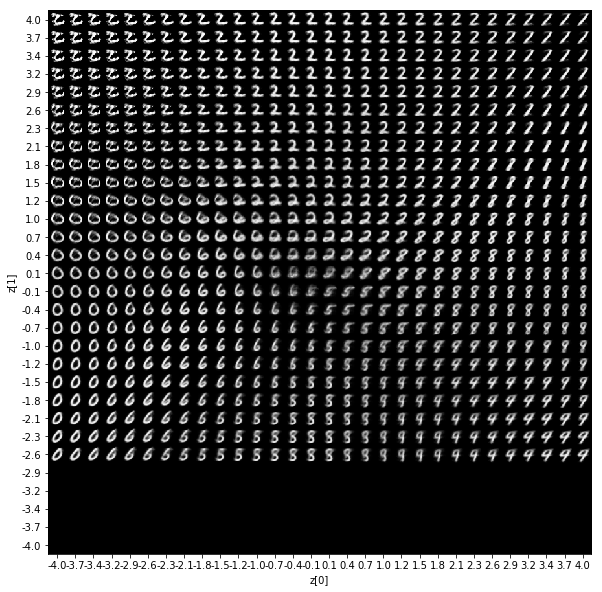

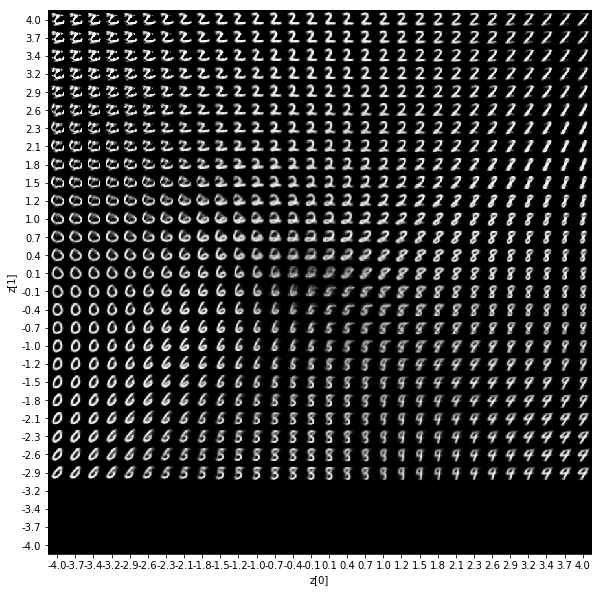

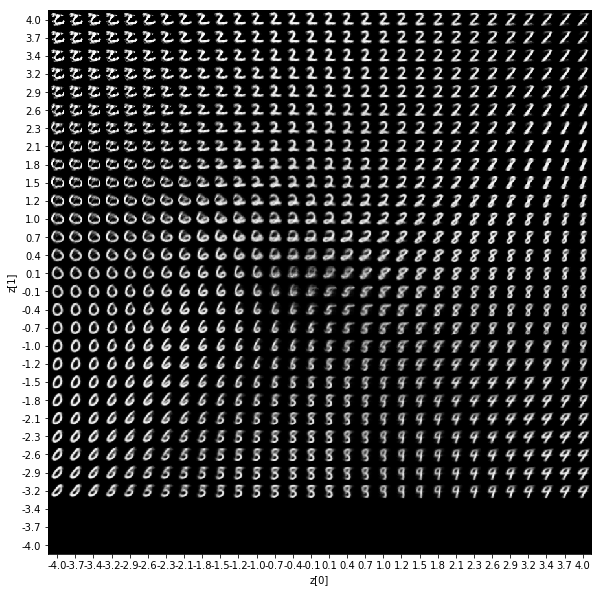

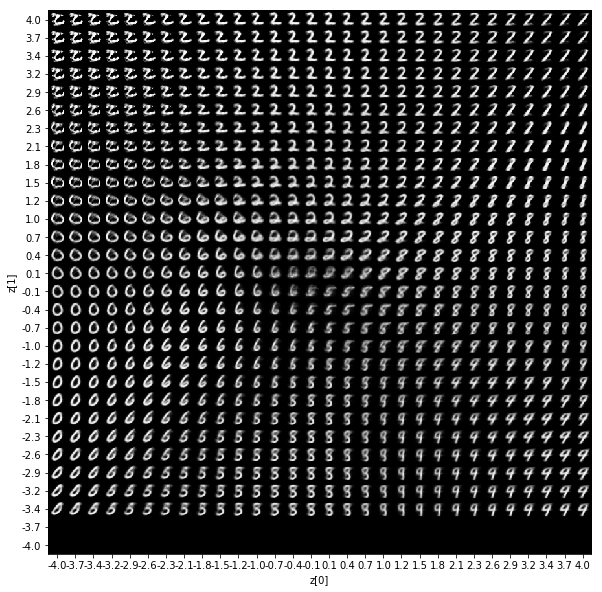

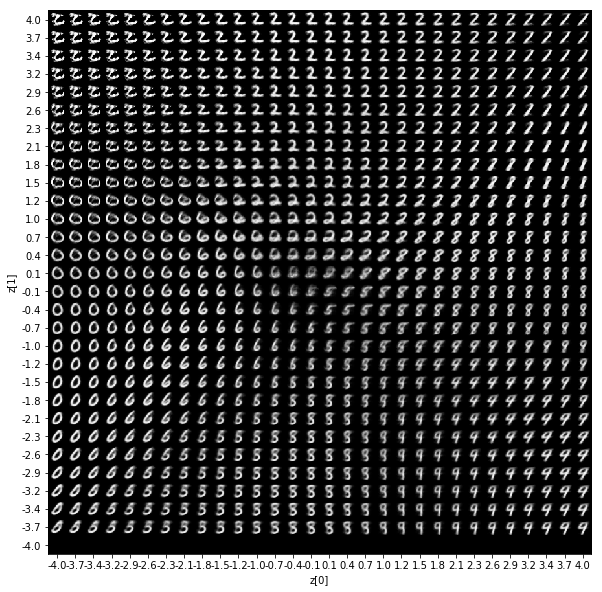

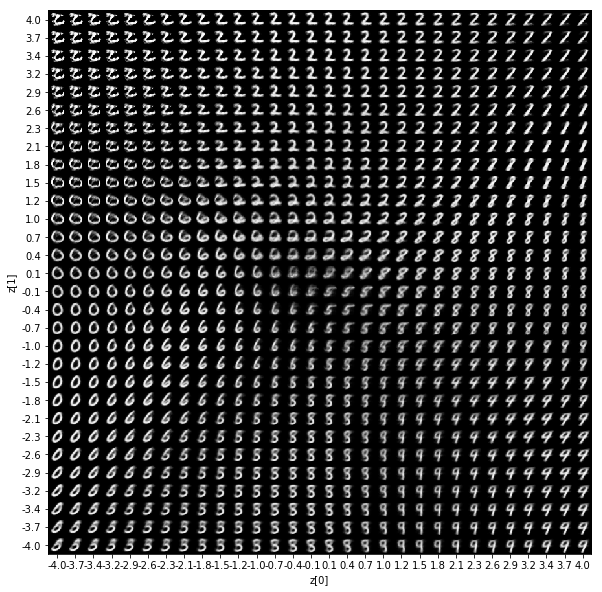

In [78]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
             j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()